In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data = pd.read_csv('Dataset/TC2/train.csv')

In [4]:
data

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.134012,0.466469,-0.051024
1,-0.202646,0.543844,-0.040844
2,-0.202646,0.543844,-0.040844
3,-0.267686,0.621683,-0.031170
4,-0.299013,0.660611,-0.026600
...,...,...,...
2943,-1.211667,0.883520,-0.000159
2944,-1.211675,0.883522,-0.000159
2945,-1.211683,0.883522,-0.000159
2946,-1.211691,0.883519,-0.000159


In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_max_scaled = data.copy()
columns_to_scale = ['velocity_data_x', 'velocity_data_y', 'velocity_data_z']

scaler = MinMaxScaler()
for column in columns_to_scale:
    df_max_scaled[column] = scaler.fit_transform(np.array(df_max_scaled[column]).reshape(-1, 1) )
    
df_max_scaled

,velocity_data_x,velocity_data_y,velocity_data_z
0,0.987465,0.140303,0.000000
1,0.934934,0.193936,0.117364
2,0.934934,0.193936,0.117364
3,0.885153,0.247892,0.228894
4,0.861175,0.274875,0.281580
...,...,...,...
2943,0.162641,0.429388,0.586414
2944,0.162635,0.429389,0.586414
2945,0.162629,0.429389,0.586414
2946,0.162623,0.429387,0.586414


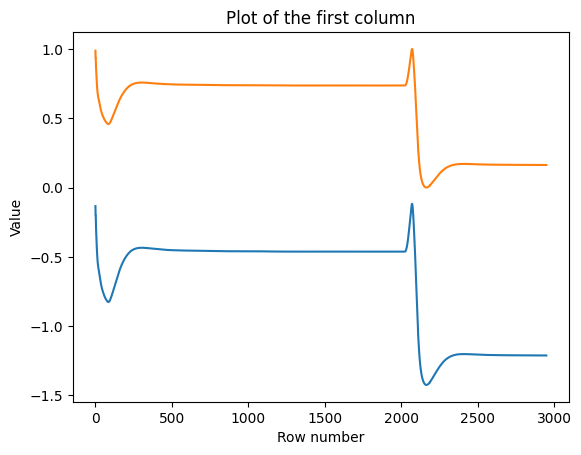

In [6]:
plt.plot(data['velocity_data_x'])
plt.plot(df_max_scaled['velocity_data_x'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

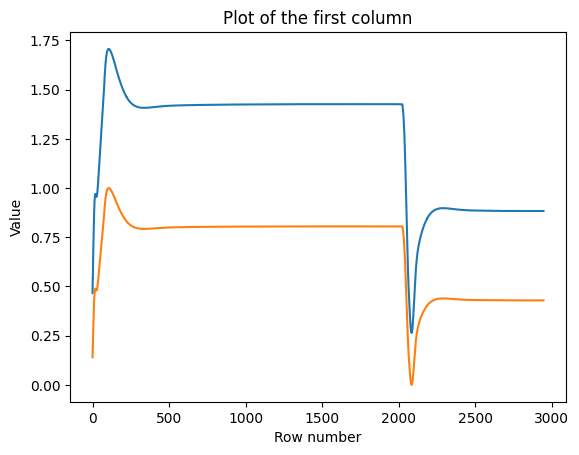

In [7]:
plt.plot(data['velocity_data_y'])
plt.plot(df_max_scaled['velocity_data_y'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

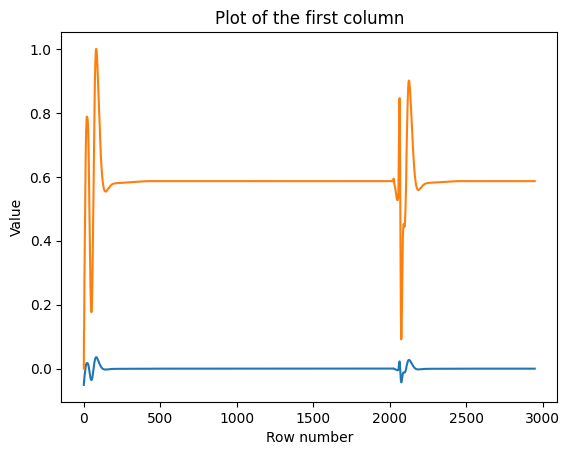

In [8]:
plt.plot(data['velocity_data_z'])
plt.plot(df_max_scaled['velocity_data_z'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

In [9]:
sequence_size = 4
sequences = []

for i in range(len(data) - sequence_size + 1):
    sequence = data.iloc[i:i + sequence_size]
    sequences.append(sequence)

sequences_df = pd.concat(sequences, ignore_index=True)

sequences_df

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.134012,0.466469,-0.051024
1,-0.202646,0.543844,-0.040844
2,-0.202646,0.543844,-0.040844
3,-0.267686,0.621683,-0.031170
4,-0.202646,0.543844,-0.040844
...,...,...,...
11775,-1.211691,0.883519,-0.000159
11776,-1.211675,0.883522,-0.000159
11777,-1.211683,0.883522,-0.000159
11778,-1.211691,0.883519,-0.000159


In [10]:
x_train = sequences_df.values.tolist()
x_train

[[-0.134012, 0.466469, -0.051024],
 [-0.202646, 0.543844, -0.040844],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.202646, 0.543844, -0.040844],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.202646, 0.543844, -0.040844],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.267686, 0.621683, -0.03117],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.299013, 0.660611, -0.0266],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.329513, 0.699309, -0.022177],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.414533, 0.809782, -0.009355],
 [-0.359074, 0.737451, -0.0179],
 [-0.387509, 0.774519, -0.013663],
 [-0.414533, 0.809782, -0.009355],
 [-0.439797, 0.842406, -0.005043],
 [-0.387509, 0.774519, -0.013663],
 [-0.

In [11]:
class EarlyStopping:
    def __init__(self, patience=20, monitor='val_loss', mode='min', min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif (self.mode == 'min' and self.best_loss - val_loss >= self.min_delta) or \
             (self.mode == 'max' and val_loss - self.best_loss >= self.min_delta):
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
            return False



In [12]:
es = EarlyStopping(patience=20, monitor='val_loss', mode='min', min_delta=1e-5, restore_best_weights=True)

In [13]:
input_size = 3
output_size_forward= (1,3)
output_size_backward = (1,3)
dropout = 0.1
num_layers=1
hidden_size=64
num_epochs=100
learning_rate=0.01
num_steps=1


In [18]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Determine device
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias=True, batch_first=True, dropout=dropout, bidirectional=True).to(self.device)  # Move LSTM to device
        self.fc_1 = nn.Linear(hidden_size * 2, 128).to(self.device)  # Move Linear layers to device
        self.relu1 = nn.ReLU()
        self.fc_2 = nn.Linear(128, input_size).to(self.device)
        self._init_weights()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)  # Move initial states to device
        c0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)

        out, _ = self.rnn(x, (h0))
        out = self.fc_1(out)
        out = self.relu1(out)
        out = self.fc_2(out)

        return out

    def _init_weights(self):
        for layer in [self.rnn, self.fc_1, self.fc_2]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.RNN):
                for name, param in layer.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        nn.init.kaiming_normal_(param.data, nonlinearity='relu')
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)

In [19]:
model = Model(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
model.to(device)
model.train()

Model(
  (rnn): RNN(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [21]:
predicted_vectors = []

last_index = len(x_train) - 4
num_sequences = last_index // 4

for epoch in range(num_epochs):
    predicted_vectors.clear()
    total_loss = 0
    
    for idx in range(0, last_index, 4):
        sequence = torch.tensor(x_train[idx: idx + 4]).to(device)  
        optimizer.zero_grad()

        out_forward = model(sequence)
        predicted_next_element_1 = out_forward[-1, :].view(-1, 3)
        target_next_element = torch.tensor(x_train[idx + 7]).view(-1, 3).to(device)

        loss_forward_1 = criterion(predicted_next_element_1, target_next_element)
        total_loss += loss_forward_1.item()
        
        loss_forward_1.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Sequence {idx // 4 + 1}/{num_sequences}, Loss: {loss_forward_1.item()}")

        predicted_vectors.append(predicted_next_element_1.detach().cpu().numpy())

    # Calculate average loss for the epoch
    avg_loss = total_loss / num_sequences

    # Check for early stopping
    if es(model, avg_loss):
        print("Early stopping triggered.")
        break


Epoch 1/100, Sequence 1/2944, Loss: 0.4544156491756439
Epoch 1/100, Sequence 26/2944, Loss: 0.011267523281276226
Epoch 1/100, Sequence 51/2944, Loss: 0.0010822158074006438
Epoch 1/100, Sequence 76/2944, Loss: 7.510143041145056e-05
Epoch 1/100, Sequence 101/2944, Loss: 7.130467565730214e-06
Epoch 1/100, Sequence 126/2944, Loss: 5.367764401853492e-07
Epoch 1/100, Sequence 151/2944, Loss: 4.602562512445729e-06
Epoch 1/100, Sequence 176/2944, Loss: 4.230997490139998e-07
Epoch 1/100, Sequence 201/2944, Loss: 9.796508493309375e-09
Epoch 1/100, Sequence 226/2944, Loss: 1.0951252988888882e-06
Epoch 1/100, Sequence 251/2944, Loss: 9.315094473549834e-09
Epoch 1/100, Sequence 276/2944, Loss: 7.757254394391566e-09
Epoch 1/100, Sequence 301/2944, Loss: 5.89582882515316e-10
Epoch 1/100, Sequence 326/2944, Loss: 3.2621423340373212e-09
Epoch 1/100, Sequence 351/2944, Loss: 9.937917155866671e-11
Epoch 1/100, Sequence 376/2944, Loss: 2.848790181531058e-08
Epoch 1/100, Sequence 401/2944, Loss: 1.29363386

Epoch 2/100, Sequence 426/2944, Loss: 4.684922935704883e-11
Epoch 2/100, Sequence 451/2944, Loss: 2.79244405376744e-09
Epoch 2/100, Sequence 476/2944, Loss: 7.749904884502001e-11
Epoch 2/100, Sequence 501/2944, Loss: 3.8506222516110356e-11
Epoch 2/100, Sequence 526/2944, Loss: 3.6144288517031553e-12
Epoch 2/100, Sequence 551/2944, Loss: 4.678126774848579e-10
Epoch 2/100, Sequence 576/2944, Loss: 5.63808982140257e-13
Epoch 2/100, Sequence 601/2944, Loss: 1.202147582868296e-11
Epoch 2/100, Sequence 626/2944, Loss: 1.6400336644295521e-09
Epoch 2/100, Sequence 651/2944, Loss: 4.248009582985546e-11
Epoch 2/100, Sequence 676/2944, Loss: 3.1904357628009805e-12
Epoch 2/100, Sequence 701/2944, Loss: 2.178463312518808e-11
Epoch 2/100, Sequence 726/2944, Loss: 1.0280841282461761e-11
Epoch 2/100, Sequence 751/2944, Loss: 1.1281554683495454e-11
Epoch 2/100, Sequence 776/2944, Loss: 7.881991725966486e-10
Epoch 2/100, Sequence 801/2944, Loss: 9.354561569807629e-11
Epoch 2/100, Sequence 826/2944, Loss

Epoch 3/100, Sequence 876/2944, Loss: 1.0667669872455043e-11
Epoch 3/100, Sequence 901/2944, Loss: 5.482938322115549e-12
Epoch 3/100, Sequence 926/2944, Loss: 1.9266328983580383e-12
Epoch 3/100, Sequence 951/2944, Loss: 4.944595080602632e-12
Epoch 3/100, Sequence 976/2944, Loss: 2.138737754606157e-12
Epoch 3/100, Sequence 1001/2944, Loss: 6.523171759698076e-13
Epoch 3/100, Sequence 1026/2944, Loss: 3.703625513912234e-12
Epoch 3/100, Sequence 1051/2944, Loss: 1.2103715599232068e-11
Epoch 3/100, Sequence 1076/2944, Loss: 4.753413374719573e-12
Epoch 3/100, Sequence 1101/2944, Loss: 8.638464943366841e-12
Epoch 3/100, Sequence 1126/2944, Loss: 1.6508931374725755e-11
Epoch 3/100, Sequence 1151/2944, Loss: 3.297679620692384e-12
Epoch 3/100, Sequence 1176/2944, Loss: 3.07640912744489e-10
Epoch 3/100, Sequence 1201/2944, Loss: 5.5623030487117475e-11
Epoch 3/100, Sequence 1226/2944, Loss: 1.1591172466296484e-11
Epoch 3/100, Sequence 1251/2944, Loss: 2.5148251536766253e-11
Epoch 3/100, Sequence 1

Epoch 4/100, Sequence 1301/2944, Loss: 3.4886382671572846e-09
Epoch 4/100, Sequence 1326/2944, Loss: 1.419250338585698e-06
Epoch 4/100, Sequence 1351/2944, Loss: 5.105995569465449e-06
Epoch 4/100, Sequence 1376/2944, Loss: 1.000056272459915e-06
Epoch 4/100, Sequence 1401/2944, Loss: 3.6978849493607413e-07
Epoch 4/100, Sequence 1426/2944, Loss: 2.3156342194852186e-06
Epoch 4/100, Sequence 1451/2944, Loss: 2.078949910355732e-05
Epoch 4/100, Sequence 1476/2944, Loss: 5.085979637442506e-07
Epoch 4/100, Sequence 1501/2944, Loss: 4.997219971158984e-09
Epoch 4/100, Sequence 1526/2944, Loss: 1.9731473344108963e-08
Epoch 4/100, Sequence 1551/2944, Loss: 7.667337875716385e-10
Epoch 4/100, Sequence 1576/2944, Loss: 5.6950157159008086e-06
Epoch 4/100, Sequence 1601/2944, Loss: 6.046691123628989e-05
Epoch 4/100, Sequence 1626/2944, Loss: 3.291667326266179e-06
Epoch 4/100, Sequence 1651/2944, Loss: 2.544896631206939e-07
Epoch 4/100, Sequence 1676/2944, Loss: 3.1869637950876495e-07
Epoch 4/100, Seque

Epoch 5/100, Sequence 1751/2944, Loss: 3.592405539709631e-11
Epoch 5/100, Sequence 1776/2944, Loss: 6.305386768268306e-12
Epoch 5/100, Sequence 1801/2944, Loss: 4.212011989190856e-11
Epoch 5/100, Sequence 1826/2944, Loss: 1.3744584897307233e-12
Epoch 5/100, Sequence 1851/2944, Loss: 1.3593756112081912e-12
Epoch 5/100, Sequence 1876/2944, Loss: 3.3751143546645324e-10
Epoch 5/100, Sequence 1901/2944, Loss: 2.8342867983144338e-11
Epoch 5/100, Sequence 1926/2944, Loss: 1.0526794280013574e-12
Epoch 5/100, Sequence 1951/2944, Loss: 1.2845396968330647e-10
Epoch 5/100, Sequence 1976/2944, Loss: 6.077722960323717e-12
Epoch 5/100, Sequence 2001/2944, Loss: 1.1256611961996121e-11
Epoch 5/100, Sequence 2026/2944, Loss: 2.7573587431106716e-06
Epoch 5/100, Sequence 2051/2944, Loss: 9.917732313624583e-06
Epoch 5/100, Sequence 2076/2944, Loss: 0.004472245462238789
Epoch 5/100, Sequence 2101/2944, Loss: 0.00015809660544618964
Epoch 5/100, Sequence 2126/2944, Loss: 0.00014016777276992798
Epoch 5/100, Se

Epoch 6/100, Sequence 2176/2944, Loss: 1.0017598469858058e-05
Epoch 6/100, Sequence 2201/2944, Loss: 8.586381454733782e-07
Epoch 6/100, Sequence 2226/2944, Loss: 2.134345855608899e-08
Epoch 6/100, Sequence 2251/2944, Loss: 2.1843163722223835e-08
Epoch 6/100, Sequence 2276/2944, Loss: 3.4836361351153755e-07
Epoch 6/100, Sequence 2301/2944, Loss: 3.719505770050091e-08
Epoch 6/100, Sequence 2326/2944, Loss: 5.290648807942944e-09
Epoch 6/100, Sequence 2351/2944, Loss: 1.1726025483937974e-08
Epoch 6/100, Sequence 2376/2944, Loss: 3.913100954378024e-09
Epoch 6/100, Sequence 2401/2944, Loss: 1.1886548412221032e-09
Epoch 6/100, Sequence 2426/2944, Loss: 4.724448610105014e-11
Epoch 6/100, Sequence 2451/2944, Loss: 1.4750276000619067e-10
Epoch 6/100, Sequence 2476/2944, Loss: 1.0126811715582829e-11
Epoch 6/100, Sequence 2501/2944, Loss: 3.740722842593414e-09
Epoch 6/100, Sequence 2526/2944, Loss: 8.134477813559471e-11
Epoch 6/100, Sequence 2551/2944, Loss: 1.5072115430725397e-11
Epoch 6/100, Seq

Epoch 7/100, Sequence 2601/2944, Loss: 1.1482126881234844e-11
Epoch 7/100, Sequence 2626/2944, Loss: 5.008472803158526e-12
Epoch 7/100, Sequence 2651/2944, Loss: 5.653764782731496e-12
Epoch 7/100, Sequence 2676/2944, Loss: 5.896329865334726e-12
Epoch 7/100, Sequence 2701/2944, Loss: 1.8057400193172146e-12
Epoch 7/100, Sequence 2726/2944, Loss: 4.720124291424099e-11
Epoch 7/100, Sequence 2751/2944, Loss: 6.503393743667596e-13
Epoch 7/100, Sequence 2776/2944, Loss: 5.825358858485563e-12
Epoch 7/100, Sequence 2801/2944, Loss: 4.887455457708301e-13
Epoch 7/100, Sequence 2826/2944, Loss: 2.7866368067230862e-12
Epoch 7/100, Sequence 2851/2944, Loss: 6.491349341733454e-13
Epoch 7/100, Sequence 2876/2944, Loss: 1.664725215316798e-13
Epoch 7/100, Sequence 2901/2944, Loss: 1.0744908652063345e-12
Epoch 7/100, Sequence 2926/2944, Loss: 2.3226882656796066e-12
Epoch 8/100, Sequence 1/2944, Loss: 0.09007033705711365
Epoch 8/100, Sequence 26/2944, Loss: 0.0017810172867029905
Epoch 8/100, Sequence 51/2

Epoch 9/100, Sequence 126/2944, Loss: 8.344480875166482e-07
Epoch 9/100, Sequence 151/2944, Loss: 3.5323835163580952e-06
Epoch 9/100, Sequence 176/2944, Loss: 1.7666798157733865e-07
Epoch 9/100, Sequence 201/2944, Loss: 0.00045731215504929423
Epoch 9/100, Sequence 226/2944, Loss: 1.1486057701404206e-05
Epoch 9/100, Sequence 251/2944, Loss: 3.61453885489027e-06
Epoch 9/100, Sequence 276/2944, Loss: 4.778002704597384e-08
Epoch 9/100, Sequence 301/2944, Loss: 2.0309620651914884e-08
Epoch 9/100, Sequence 326/2944, Loss: 3.1231289776556537e-10
Epoch 9/100, Sequence 351/2944, Loss: 1.279491512740094e-09
Epoch 9/100, Sequence 376/2944, Loss: 6.369583527288114e-09
Epoch 9/100, Sequence 401/2944, Loss: 8.797079731337476e-10
Epoch 9/100, Sequence 426/2944, Loss: 3.043211516118305e-10
Epoch 9/100, Sequence 451/2944, Loss: 3.900649581112248e-09
Epoch 9/100, Sequence 476/2944, Loss: 2.207526245134872e-10
Epoch 9/100, Sequence 501/2944, Loss: 8.353243097225516e-11
Epoch 9/100, Sequence 526/2944, Los

Epoch 10/100, Sequence 551/2944, Loss: 1.322036924378267e-10
Epoch 10/100, Sequence 576/2944, Loss: 2.8574508210976735e-12
Epoch 10/100, Sequence 601/2944, Loss: 5.923290937598358e-12
Epoch 10/100, Sequence 626/2944, Loss: 2.3147783689836388e-10
Epoch 10/100, Sequence 651/2944, Loss: 1.6998068534321287e-12
Epoch 10/100, Sequence 676/2944, Loss: 3.1518468390778764e-12
Epoch 10/100, Sequence 701/2944, Loss: 3.0476877965757154e-11
Epoch 10/100, Sequence 726/2944, Loss: 4.9522495479403794e-12
Epoch 10/100, Sequence 751/2944, Loss: 1.9228802577986315e-12
Epoch 10/100, Sequence 776/2944, Loss: 2.0602769490452033e-10
Epoch 10/100, Sequence 801/2944, Loss: 2.2402120089526356e-11
Epoch 10/100, Sequence 826/2944, Loss: 1.3837305867098193e-12
Epoch 10/100, Sequence 851/2944, Loss: 1.8173060278847686e-11
Epoch 10/100, Sequence 876/2944, Loss: 4.297790422158609e-12
Epoch 10/100, Sequence 901/2944, Loss: 2.150286892987907e-12
Epoch 10/100, Sequence 926/2944, Loss: 3.018458692629483e-13
Epoch 10/100,

Epoch 11/100, Sequence 976/2944, Loss: 2.7337567973240162e-12
Epoch 11/100, Sequence 1001/2944, Loss: 9.848355854782942e-13
Epoch 11/100, Sequence 1026/2944, Loss: 7.833345517377355e-13
Epoch 11/100, Sequence 1051/2944, Loss: 4.81947164468477e-13
Epoch 11/100, Sequence 1076/2944, Loss: 1.8944529105169305e-12
Epoch 11/100, Sequence 1101/2944, Loss: 2.3157661552253295e-11
Epoch 11/100, Sequence 1126/2944, Loss: 2.65219351472043e-13
Epoch 11/100, Sequence 1151/2944, Loss: 2.1042622668204086e-13
Epoch 11/100, Sequence 1176/2944, Loss: 1.966702625408323e-12
Epoch 11/100, Sequence 1201/2944, Loss: 4.079209192653366e-12
Epoch 11/100, Sequence 1226/2944, Loss: 1.1818412188561306e-13
Epoch 11/100, Sequence 1251/2944, Loss: 1.8561166492681025e-11
Epoch 11/100, Sequence 1276/2944, Loss: 4.875118971708892e-12
Epoch 11/100, Sequence 1301/2944, Loss: 1.0422717376668e-12
Epoch 11/100, Sequence 1326/2944, Loss: 6.295989337518071e-12
Epoch 11/100, Sequence 1351/2944, Loss: 7.96974292116559e-12
Epoch 11

Epoch 12/100, Sequence 1401/2944, Loss: 9.21564387301732e-12
Epoch 12/100, Sequence 1426/2944, Loss: 6.291582532735873e-11
Epoch 12/100, Sequence 1451/2944, Loss: 9.319069821378534e-12
Epoch 12/100, Sequence 1476/2944, Loss: 2.0592274413422373e-11
Epoch 12/100, Sequence 1501/2944, Loss: 9.711334514328485e-11
Epoch 12/100, Sequence 1526/2944, Loss: 8.25267978954436e-12
Epoch 12/100, Sequence 1551/2944, Loss: 2.7798374713228213e-10
Epoch 12/100, Sequence 1576/2944, Loss: 2.061337732450763e-11
Epoch 12/100, Sequence 1601/2944, Loss: 1.0008060352673098e-11
Epoch 12/100, Sequence 1626/2944, Loss: 1.4696509287315251e-10
Epoch 12/100, Sequence 1651/2944, Loss: 1.9691795936915835e-12
Epoch 12/100, Sequence 1676/2944, Loss: 1.3395282105754802e-10
Epoch 12/100, Sequence 1701/2944, Loss: 2.0015624574432067e-11
Epoch 12/100, Sequence 1726/2944, Loss: 8.876874929564238e-12
Epoch 12/100, Sequence 1751/2944, Loss: 7.838329985077053e-11
Epoch 12/100, Sequence 1776/2944, Loss: 2.202590974192953e-12
Epo

Epoch 13/100, Sequence 1826/2944, Loss: 7.709528154764556e-11
Epoch 13/100, Sequence 1851/2944, Loss: 2.3264834503322618e-11
Epoch 13/100, Sequence 1876/2944, Loss: 1.3353632644097502e-09
Epoch 13/100, Sequence 1901/2944, Loss: 2.3630907994287575e-11
Epoch 13/100, Sequence 1926/2944, Loss: 2.1328541363607734e-11
Epoch 13/100, Sequence 1951/2944, Loss: 4.6482036969441864e-12
Epoch 13/100, Sequence 1976/2944, Loss: 2.850407687660095e-10
Epoch 13/100, Sequence 2001/2944, Loss: 1.9564549633144246e-11
Epoch 13/100, Sequence 2026/2944, Loss: 1.2694483302766457e-05
Epoch 13/100, Sequence 2051/2944, Loss: 0.00010527974518481642
Epoch 13/100, Sequence 2076/2944, Loss: 0.003345438977703452
Epoch 13/100, Sequence 2101/2944, Loss: 0.0001548921864014119
Epoch 13/100, Sequence 2126/2944, Loss: 3.194516466464847e-05
Epoch 13/100, Sequence 2151/2944, Loss: 2.266282081109239e-06
Epoch 13/100, Sequence 2176/2944, Loss: 2.802959215841838e-07
Epoch 13/100, Sequence 2201/2944, Loss: 5.103122475702548e-07
E

Epoch 14/100, Sequence 2251/2944, Loss: 1.385867420822251e-08
Epoch 14/100, Sequence 2276/2944, Loss: 4.6240211304393597e-07
Epoch 14/100, Sequence 2301/2944, Loss: 4.1753303037239675e-08
Epoch 14/100, Sequence 2326/2944, Loss: 4.1515257898083746e-10
Epoch 14/100, Sequence 2351/2944, Loss: 8.368457038443466e-09
Epoch 14/100, Sequence 2376/2944, Loss: 1.250242354089437e-09
Epoch 14/100, Sequence 2401/2944, Loss: 2.8130453522123844e-10
Epoch 14/100, Sequence 2426/2944, Loss: 2.8093784243399256e-11
Epoch 14/100, Sequence 2451/2944, Loss: 7.54588613816054e-11
Epoch 14/100, Sequence 2476/2944, Loss: 1.1004435210293373e-11
Epoch 14/100, Sequence 2501/2944, Loss: 1.913615266246893e-09
Epoch 14/100, Sequence 2526/2944, Loss: 5.372608469222939e-10
Epoch 14/100, Sequence 2551/2944, Loss: 1.4703417303141286e-11
Epoch 14/100, Sequence 2576/2944, Loss: 1.1987059836491426e-13
Epoch 14/100, Sequence 2601/2944, Loss: 3.541713450294637e-11
Epoch 14/100, Sequence 2626/2944, Loss: 2.132685304398474e-12
E

Epoch 15/100, Sequence 2676/2944, Loss: 2.5727431296473924e-10
Epoch 15/100, Sequence 2701/2944, Loss: 9.391788562129744e-12
Epoch 15/100, Sequence 2726/2944, Loss: 9.041028342648971e-11
Epoch 15/100, Sequence 2751/2944, Loss: 2.4618381985752613e-11
Epoch 15/100, Sequence 2776/2944, Loss: 1.612130567929526e-11
Epoch 15/100, Sequence 2801/2944, Loss: 7.761092983560314e-12
Epoch 15/100, Sequence 2826/2944, Loss: 6.552440881546495e-14
Epoch 15/100, Sequence 2851/2944, Loss: 1.1478264085734713e-12
Epoch 15/100, Sequence 2876/2944, Loss: 1.921636981483399e-11
Epoch 15/100, Sequence 2901/2944, Loss: 2.170823633698693e-12
Epoch 15/100, Sequence 2926/2944, Loss: 3.697414770187368e-12
Epoch 16/100, Sequence 1/2944, Loss: 0.4458867013454437
Epoch 16/100, Sequence 26/2944, Loss: 0.002028605667874217
Epoch 16/100, Sequence 51/2944, Loss: 4.720702418126166e-05
Epoch 16/100, Sequence 76/2944, Loss: 1.855797745520249e-05
Epoch 16/100, Sequence 101/2944, Loss: 7.230650226119906e-06
Epoch 16/100, Seque

Epoch 17/100, Sequence 151/2944, Loss: 1.4302060662885197e-05
Epoch 17/100, Sequence 176/2944, Loss: 1.2500042885221774e-06
Epoch 17/100, Sequence 201/2944, Loss: 2.542567472119117e-07
Epoch 17/100, Sequence 226/2944, Loss: 1.5818423548807914e-07
Epoch 17/100, Sequence 251/2944, Loss: 9.141833601233884e-08
Epoch 17/100, Sequence 276/2944, Loss: 2.6821382448360964e-08
Epoch 17/100, Sequence 301/2944, Loss: 1.1208405759077777e-08
Epoch 17/100, Sequence 326/2944, Loss: 2.37712138861923e-09
Epoch 17/100, Sequence 351/2944, Loss: 1.010197792084e-08
Epoch 17/100, Sequence 376/2944, Loss: 2.629848516733091e-08
Epoch 17/100, Sequence 401/2944, Loss: 7.924906064715742e-09
Epoch 17/100, Sequence 426/2944, Loss: 4.75773731523077e-09
Epoch 17/100, Sequence 451/2944, Loss: 7.289949532918172e-09
Epoch 17/100, Sequence 476/2944, Loss: 9.226320818456202e-10
Epoch 17/100, Sequence 501/2944, Loss: 5.2998622157574e-10
Epoch 17/100, Sequence 526/2944, Loss: 6.851634259952277e-10
Epoch 17/100, Sequence 551

Epoch 18/100, Sequence 551/2944, Loss: 3.729772046767721e-10
Epoch 18/100, Sequence 576/2944, Loss: 4.4051556846724793e-10
Epoch 18/100, Sequence 601/2944, Loss: 1.307568275876747e-09
Epoch 18/100, Sequence 626/2944, Loss: 1.3507208684870875e-09
Epoch 18/100, Sequence 651/2944, Loss: 1.5917971385448482e-09
Epoch 18/100, Sequence 676/2944, Loss: 1.8760062947542622e-10
Epoch 18/100, Sequence 701/2944, Loss: 1.96480713643421e-11
Epoch 18/100, Sequence 726/2944, Loss: 1.3063793102841004e-10
Epoch 18/100, Sequence 751/2944, Loss: 3.946379889541163e-10
Epoch 18/100, Sequence 776/2944, Loss: 5.190264329435479e-10
Epoch 18/100, Sequence 801/2944, Loss: 8.263884576642511e-10
Epoch 18/100, Sequence 826/2944, Loss: 1.4107891521675242e-09
Epoch 18/100, Sequence 851/2944, Loss: 1.0271348216406295e-09
Epoch 18/100, Sequence 876/2944, Loss: 1.885961872782893e-11
Epoch 18/100, Sequence 901/2944, Loss: 5.14977158139196e-11
Epoch 18/100, Sequence 926/2944, Loss: 1.0965964247766635e-11
Epoch 18/100, Sequ

Epoch 19/100, Sequence 951/2944, Loss: 8.072808372304452e-13
Epoch 19/100, Sequence 976/2944, Loss: 7.460821023486108e-12
Epoch 19/100, Sequence 1001/2944, Loss: 2.7003807176462225e-11
Epoch 19/100, Sequence 1026/2944, Loss: 6.392113227615681e-11
Epoch 19/100, Sequence 1051/2944, Loss: 1.6371108635393483e-10
Epoch 19/100, Sequence 1076/2944, Loss: 2.2327062421112487e-10
Epoch 19/100, Sequence 1101/2944, Loss: 2.1090609814145012e-10
Epoch 19/100, Sequence 1126/2944, Loss: 2.938484733316926e-10
Epoch 19/100, Sequence 1151/2944, Loss: 3.4195607456766197e-10
Epoch 19/100, Sequence 1176/2944, Loss: 3.158464600971911e-10
Epoch 19/100, Sequence 1201/2944, Loss: 4.433413358650995e-10
Epoch 19/100, Sequence 1226/2944, Loss: 2.4598717507373635e-10
Epoch 19/100, Sequence 1251/2944, Loss: 2.145911448536708e-09
Epoch 19/100, Sequence 1276/2944, Loss: 5.504722233595771e-10
Epoch 19/100, Sequence 1301/2944, Loss: 8.15749134908117e-10
Epoch 19/100, Sequence 1326/2944, Loss: 1.5015862164791116e-10
Epoc

Epoch 20/100, Sequence 1376/2944, Loss: 2.0936570255258857e-09
Epoch 20/100, Sequence 1401/2944, Loss: 4.919880502995966e-09
Epoch 20/100, Sequence 1426/2944, Loss: 1.6242671652122453e-09
Epoch 20/100, Sequence 1451/2944, Loss: 3.72941855175668e-09
Epoch 20/100, Sequence 1476/2944, Loss: 2.504474405640167e-10
Epoch 20/100, Sequence 1501/2944, Loss: 2.778931751379332e-09
Epoch 20/100, Sequence 1526/2944, Loss: 1.7679372410484007e-09
Epoch 20/100, Sequence 1551/2944, Loss: 1.3790530939417067e-09
Epoch 20/100, Sequence 1576/2944, Loss: 2.6836892708104187e-09
Epoch 20/100, Sequence 1601/2944, Loss: 1.5116427554140444e-10
Epoch 20/100, Sequence 1626/2944, Loss: 1.1196140542457655e-10
Epoch 20/100, Sequence 1651/2944, Loss: 1.6907146516143e-10
Epoch 20/100, Sequence 1676/2944, Loss: 3.34358185583028e-09
Epoch 20/100, Sequence 1701/2944, Loss: 1.1319667425624402e-09
Epoch 20/100, Sequence 1726/2944, Loss: 3.085087740828385e-10
Epoch 20/100, Sequence 1751/2944, Loss: 2.0600821049043816e-10
Epo

Epoch 21/100, Sequence 1801/2944, Loss: 3.119299378795404e-07
Epoch 21/100, Sequence 1826/2944, Loss: 1.9880893376011954e-07
Epoch 21/100, Sequence 1851/2944, Loss: 1.0353301149734762e-07
Epoch 21/100, Sequence 1876/2944, Loss: 1.1157140988871106e-07
Epoch 21/100, Sequence 1901/2944, Loss: 8.889003311196575e-08
Epoch 21/100, Sequence 1926/2944, Loss: 6.459455903495837e-08
Epoch 21/100, Sequence 1951/2944, Loss: 4.681456289290509e-08
Epoch 21/100, Sequence 1976/2944, Loss: 2.7186812801005544e-08
Epoch 21/100, Sequence 2001/2944, Loss: 2.0624097984978107e-08
Epoch 21/100, Sequence 2026/2944, Loss: 0.0002956669486593455
Epoch 21/100, Sequence 2051/2944, Loss: 0.13191933929920197
Epoch 21/100, Sequence 2076/2944, Loss: 0.35614025592803955
Epoch 21/100, Sequence 2101/2944, Loss: 0.295406311750412
Epoch 21/100, Sequence 2126/2944, Loss: 0.1537318080663681
Epoch 21/100, Sequence 2151/2944, Loss: 0.006758443079888821
Epoch 21/100, Sequence 2176/2944, Loss: 0.0003138674655929208
Epoch 21/100, S

Epoch 22/100, Sequence 2226/2944, Loss: 3.7080303627590183e-07
Epoch 22/100, Sequence 2251/2944, Loss: 1.3649150787387043e-07
Epoch 22/100, Sequence 2276/2944, Loss: 2.65642711383407e-07
Epoch 22/100, Sequence 2301/2944, Loss: 3.834566797422667e-08
Epoch 22/100, Sequence 2326/2944, Loss: 2.665902609777504e-09
Epoch 22/100, Sequence 2351/2944, Loss: 6.263457308364195e-09
Epoch 22/100, Sequence 2376/2944, Loss: 1.3701155765488693e-09
Epoch 22/100, Sequence 2401/2944, Loss: 5.982725426179059e-10
Epoch 22/100, Sequence 2426/2944, Loss: 8.014294089475626e-11
Epoch 22/100, Sequence 2451/2944, Loss: 3.972974171873034e-10
Epoch 22/100, Sequence 2476/2944, Loss: 7.561046233561797e-11
Epoch 22/100, Sequence 2501/2944, Loss: 7.074905938875276e-11
Epoch 22/100, Sequence 2526/2944, Loss: 2.986845770713842e-10
Epoch 22/100, Sequence 2551/2944, Loss: 2.3365814491582704e-11
Epoch 22/100, Sequence 2576/2944, Loss: 4.4376093077946877e-11
Epoch 22/100, Sequence 2601/2944, Loss: 9.874691342393049e-11
Epoc

Epoch 23/100, Sequence 2651/2944, Loss: 5.126289948087503e-10
Epoch 23/100, Sequence 2676/2944, Loss: 2.816296640339999e-10
Epoch 23/100, Sequence 2701/2944, Loss: 1.56056487177203e-10
Epoch 23/100, Sequence 2726/2944, Loss: 1.9411539042835102e-10
Epoch 23/100, Sequence 2751/2944, Loss: 9.444683229942186e-11
Epoch 23/100, Sequence 2776/2944, Loss: 1.4956993976689148e-10
Epoch 23/100, Sequence 2801/2944, Loss: 3.342246479576261e-10
Epoch 23/100, Sequence 2826/2944, Loss: 6.456808612081977e-12
Epoch 23/100, Sequence 2851/2944, Loss: 1.8601939433260384e-10
Epoch 23/100, Sequence 2876/2944, Loss: 8.469877577077511e-12
Epoch 23/100, Sequence 2901/2944, Loss: 1.485377931764731e-10
Epoch 23/100, Sequence 2926/2944, Loss: 5.237162700039155e-12
Epoch 24/100, Sequence 1/2944, Loss: 0.018976908177137375
Epoch 24/100, Sequence 26/2944, Loss: 0.0230240561068058
Epoch 24/100, Sequence 51/2944, Loss: 0.059353992342948914
Epoch 24/100, Sequence 76/2944, Loss: 0.12631095945835114
Epoch 24/100, Sequence

In [22]:
model_path = 'saved_model_RNN.pth'

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_forward_1,
}, model_path)

print("Model saved successfully!")

Model saved successfully!


In [23]:
predicted_array = np.squeeze(np.array(predicted_vectors))

df_pred = pd.DataFrame(predicted_array, columns=['velocity_data_x', 'velocity_data_y', 'velocity_data_z'])

In [24]:
df_pred

,velocity_data_x,velocity_data_y,velocity_data_z
0,-0.346442,0.893713,-0.008028
1,-0.346331,0.893481,-0.008455
2,-0.346192,0.893081,-0.009153
3,-0.346097,0.892567,-0.009980
4,-0.346109,0.891988,-0.010809
...,...,...,...
2939,-1.211658,0.883487,-0.000159
2940,-1.211668,0.883494,-0.000158
2941,-1.211680,0.883501,-0.000158
2942,-1.211692,0.883507,-0.000158


In [25]:
num_sequences = last_index // 4 
y = torch.zeros(num_sequences)
y_hat = torch.zeros(num_sequences)

In [26]:
std_dev = data.std()

In [27]:
std_dev_array = np.array(std_dev).reshape(1, -1)
std_dev_array

array([[0.35271156, 0.28579752, 0.00593083]])

In [28]:
std_dev_array = np.array(std_dev).reshape(1, -1)
std_dev_array

array([[0.35271156, 0.28579752, 0.00593083]])

In [29]:
deviation_threshold = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold
deviation_threshold_1=deviation_threshold[0][0]
deviation_threshold_2=deviation_threshold[0][1]
deviation_threshold_3=deviation_threshold[0][2]

In [30]:
for i in range(len(df_pred) - 4):
    if (abs(df_pred['velocity_data_x'][i] - data['velocity_data_y'][i + 4]) > deviation_threshold_1 or
        abs(df_pred['velocity_data_y'][i] - data['velocity_data_x'][i + 4]) > deviation_threshold_2 or
        abs(df_pred['velocity_data_z'][i] - data['velocity_data_z'][i + 4]) > deviation_threshold_3):
        y_hat[i]=1


In [31]:
y_hat

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [32]:
df_pred.shape

(2944, 3)

In [33]:
test_data=pd.read_csv('Dataset/TC2/._test.csv')

In [34]:
test_data

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.212264,0.883470,-0.000159
1,-1.212274,0.883475,-0.000159
2,-1.212285,0.883480,-0.000159
3,-1.212296,0.883486,-0.000159
4,-1.212306,0.883491,-0.000159
...,...,...,...
1995,-1.499317,8.726109,-0.000160
1996,-1.499319,0.082326,-0.000160
1997,-1.499320,37.618766,-0.000160
1998,-1.499322,1.983398,-0.000160


In [35]:
sequence_size = 4
sequences_test = []

for i in range(len(test_data) - sequence_size + 1):
    sequence_test = test_data.iloc[i:i + sequence_size]
    sequences_test.append(sequence_test)

sequences_test_df = pd.concat(sequences_test, ignore_index=True)

sequences_test_df

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.212264,0.883470,-0.000159
1,-1.212274,0.883475,-0.000159
2,-1.212285,0.883480,-0.000159
3,-1.212296,0.883486,-0.000159
4,-1.212274,0.883475,-0.000159
...,...,...,...
7983,-1.499322,1.983398,-0.000160
7984,-1.499319,0.082326,-0.000160
7985,-1.499320,37.618766,-0.000160
7986,-1.499322,1.983398,-0.000160


In [36]:
model_path = 'saved_model_RNN.pth'
checkpoint = torch.load(model_path)

In [37]:
model = Model(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Archi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model(
  (rnn): RNN(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [38]:
x_test = sequences_test_df.values.tolist()
x_test = torch.tensor(x_test).to(device)

In [39]:
with torch.no_grad():
    predicted_vectors_test = []
    for idx in range(0, len(x_test), sequence_size):
        sequence_test = x_test[idx:idx + sequence_size].to(device)  # Move input tensor to the same device as the model

        out_forward_test = model(sequence_test)
        predicted_next_element_test = out_forward_test[-1, :].view(-1, 3)
        predicted_vectors_test.append(predicted_next_element_test.cpu().numpy())


In [40]:
predicted_vectors_test

[array([[-1.2078991 ,  0.87663674, -0.01651118]], dtype=float32),
 array([[-1.2079064 ,  0.87664396, -0.01651154]], dtype=float32),
 array([[-1.2079135 ,  0.8766505 , -0.01651203]], dtype=float32),
 array([[-1.2079206 ,  0.87665784, -0.01651195]], dtype=float32),
 array([[-1.2079285 ,  0.8766642 , -0.01651343]], dtype=float32),
 array([[-1.207937  ,  0.87667066, -0.01651473]], dtype=float32),
 array([[-1.2079463 ,  0.87667704, -0.01651718]], dtype=float32),
 array([[-1.2079562 ,  0.8766832 , -0.01651978]], dtype=float32),
 array([[-1.2079662 ,  0.8766884 , -0.01652303]], dtype=float32),
 array([[-1.2079766 ,  0.87669283, -0.01652703]], dtype=float32),
 array([[-1.2079879 ,  0.8766969 , -0.01653134]], dtype=float32),
 array([[-1.2079991 ,  0.8766996 , -0.01653668]], dtype=float32),
 array([[-1.2080092 ,  0.8767014 , -0.01654159]], dtype=float32),
 array([[-1.2080199 ,  0.8767029 , -0.01654726]], dtype=float32),
 array([[-1.2080289 ,  0.8767023 , -0.01655272]], dtype=float32),
 array([[-

In [41]:
predicted_test_array = np.squeeze(np.array(predicted_vectors_test))

df_test_pred = pd.DataFrame(predicted_test_array, columns=['velocity_data_x', 'velocity_data_y', 'velocity_data_z'])

In [42]:
df_test_pred

,velocity_data_x,velocity_data_y,velocity_data_z
0,-1.207899,0.876637,-0.016511
1,-1.207906,0.876644,-0.016512
2,-1.207914,0.876651,-0.016512
3,-1.207921,0.876658,-0.016512
4,-1.207929,0.876664,-0.016513
...,...,...,...
1992,-0.536791,0.054727,0.267044
1993,-1.529806,0.555070,-0.274205
1994,-0.381640,-0.236184,0.391910
1995,-1.359574,0.869324,0.078974


In [43]:
num_sequences_1 = len(sequences_test_df) // 4 
y_test = torch.zeros(num_sequences_1)
y_hat_test = torch.zeros(num_sequences_1)

In [44]:
std_dev_1 = test_data.std()
std_dev_array_1 = np.array(std_dev_1).reshape(1, -1)
std_dev_array_1

array([[2.00598262e-01, 1.64150534e+01, 4.48844794e-03]])

In [45]:
deviation_threshold_test = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold_test
deviation_threshold_test_1=deviation_threshold_test[0][0]
deviation_threshold_test_2=deviation_threshold_test[0][1]
deviation_threshold_test_3=deviation_threshold_test[0][2]

In [46]:
len(df_test_pred)

1997

In [47]:
for i in range(len(df_test_pred)):
    if (abs(df_test_pred['velocity_data_x'][i] - test_data['velocity_data_x'][i + 3]) > deviation_threshold_test_1 or
        abs(df_test_pred['velocity_data_y'][i] - test_data['velocity_data_y'][i + 3]) > deviation_threshold_test_2 or
        abs(df_test_pred['velocity_data_z'][i] - test_data['velocity_data_z'][i + 3]) > deviation_threshold_test_3):
        y_hat_test[i]=1


In [48]:
y_hat_test.shape

torch.Size([1997])

In [49]:
y_hat_test

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [50]:
test_data_1=pd.read_csv('Dataset/TC2/test.csv')
column_4_values = test_data_1.iloc[3:, 3].values

In [51]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(column_4_values, y_hat_test)
print("Accuracy:", accuracy)


Accuracy: 1.0
